In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# read in expr_preprocessed.h5ad
expr = sc.read_h5ad('expr_preprocessed.h5ad')
expr.uns["log1p"]["base"] = None
expanding_barcodes = pd.read_csv("barcodes_expanding_vs_contracting.csv", index_col=0)
barcodes_w_sc_and_tcr = set(expanding_barcodes.index) & set(expr.obs.index)

In [3]:
# Filter barcodes to only include those with shared data
expanding_barcodes = expanding_barcodes.loc[list(barcodes_w_sc_and_tcr)]

# Label sc data to clarify which have tcr data
expr.obs["has_tcr_data"] = False
expr.obs.loc[list(barcodes_w_sc_and_tcr), "has_tcr_data"] = True

In [4]:
expr = expr[expr.obs["has_tcr_data"]]

## Check whether the expanding early clones are more likely to highly express the 'highly variable' genes

In [44]:
high_var_genes = expr.var.query("highly_variable")
expr_df = pd.DataFrame(expr.X, index=expr.obs.index, columns=expr.var.index)

def make_violin_plots_for_timepoint(timepoint: str = "early"):

   barcodes_that_expand = expanding_barcodes.query(f"{timepoint} == True").index
   barcodes_that_contract = expanding_barcodes.query(f"{timepoint} == False").index

   high_var_non_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == False").head(5).index.tolist()
   high_var_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == True").head(5).index.tolist() 
   random_5_genes = expr.var.sample(5).index.tolist()
      
   for title, genes_to_plot in zip(["High var non-TRB genes", "High var TRB genes", "Randomly selected genes"], [high_var_non_trb, high_var_trb, random_5_genes]):
      high_var_trb_expr = expr_df.loc[list(barcodes_that_expand)+list(barcodes_that_contract), genes_to_plot]

      high_var_trb_expr = high_var_trb_expr.reset_index().melt(id_vars="index").rename({"index": "barcode", "variable": "gene", "value": "expr_level"}, axis=1)

      high_var_trb_expr = high_var_trb_expr.set_index("barcode")
      high_var_trb_expr.loc[barcodes_that_expand, "kinetics"] = "expand"
      high_var_trb_expr.loc[barcodes_that_contract, "kinetics"] = "contract"

      plt.figure(figsize=(10, 5))
      sns.violinplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", split=True, linewidth=0.25)
      sns.stripplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", zorder=1, s=1.5, alpha=0.25)

      # fix legend so it only shows each state once
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys(), title=f"{timepoint} kinetics", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

      plt.title(f"Expression of high variance genes in {timepoint} expanding and contracting clones, {title}")

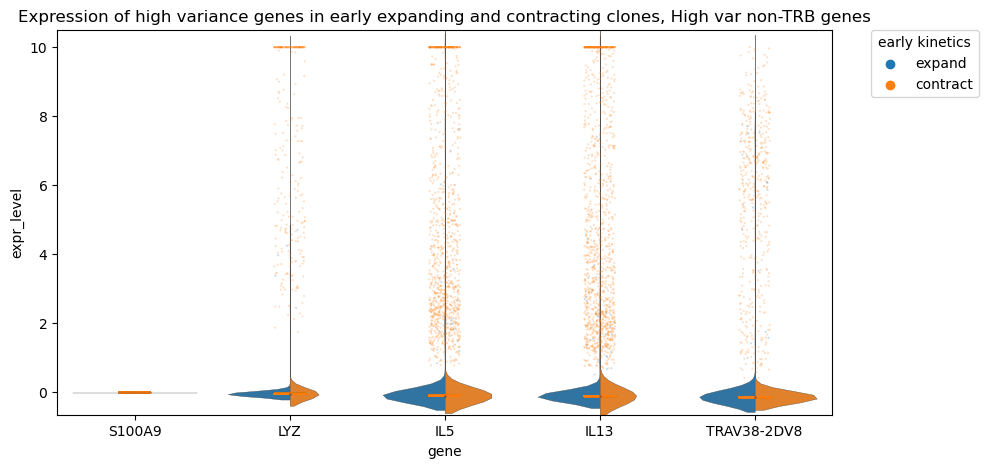

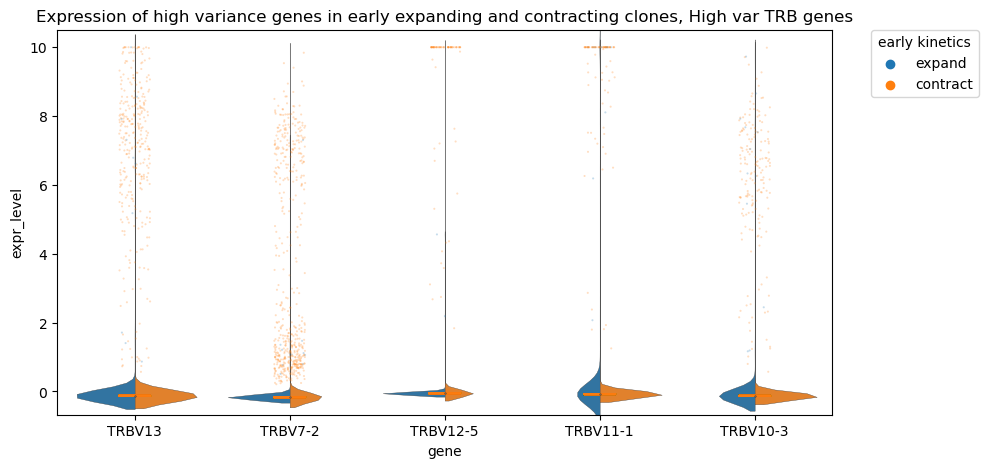

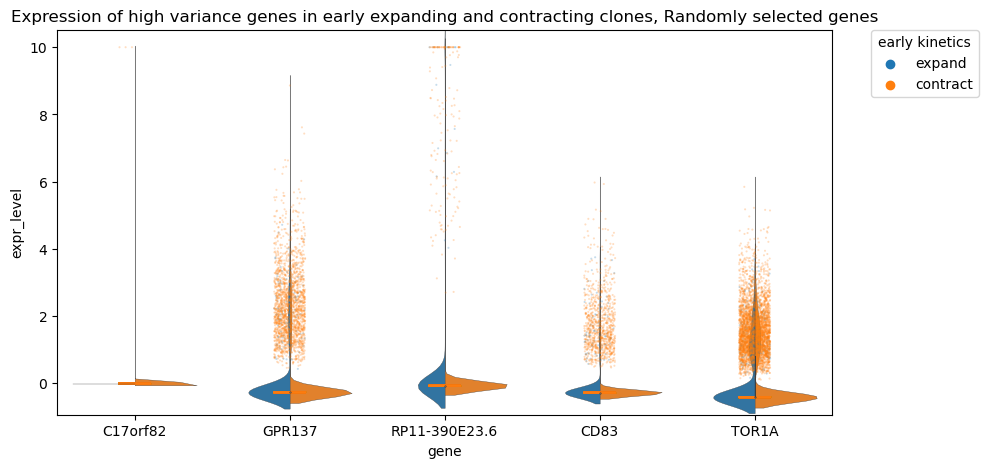

In [45]:
make_violin_plots_for_timepoint("early")

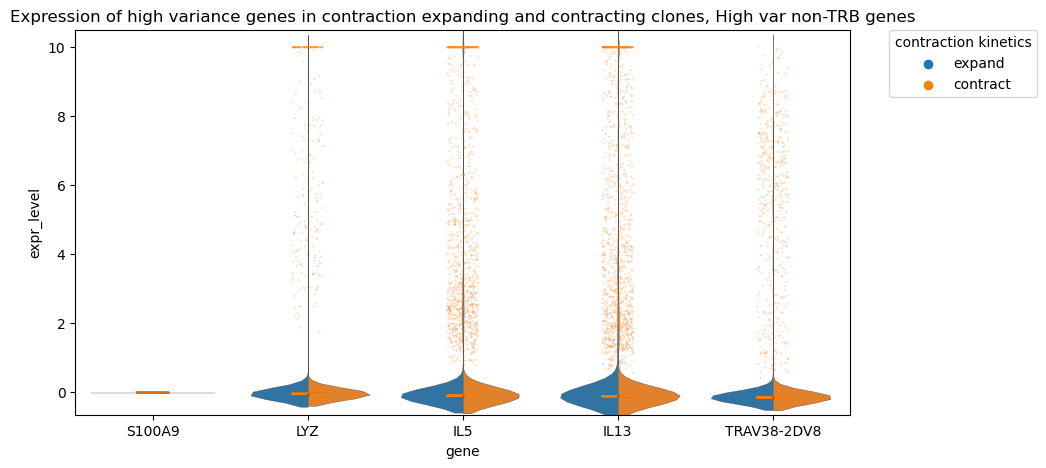

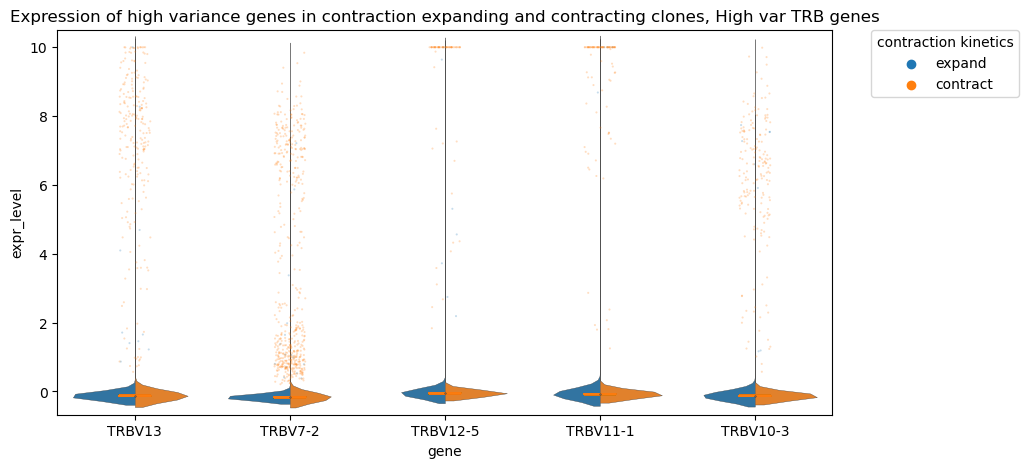

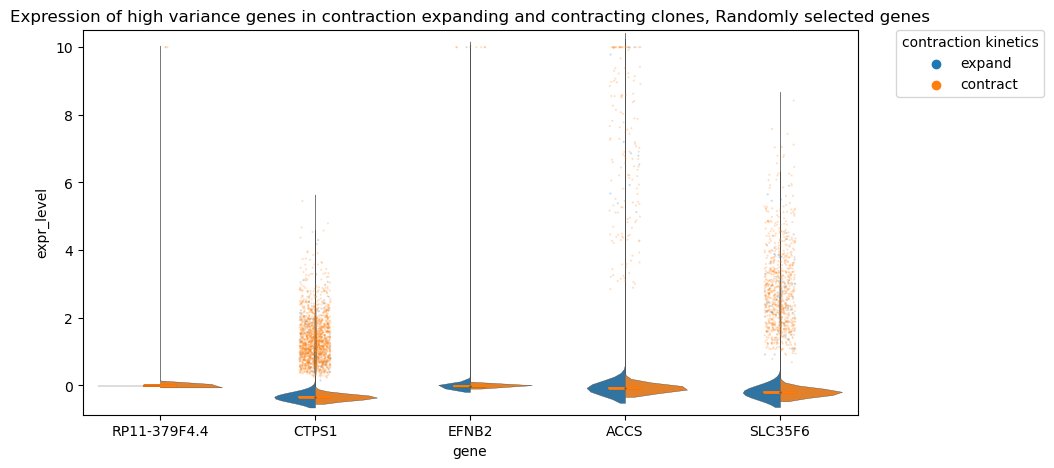

In [7]:
make_violin_plots_for_timepoint("contraction")

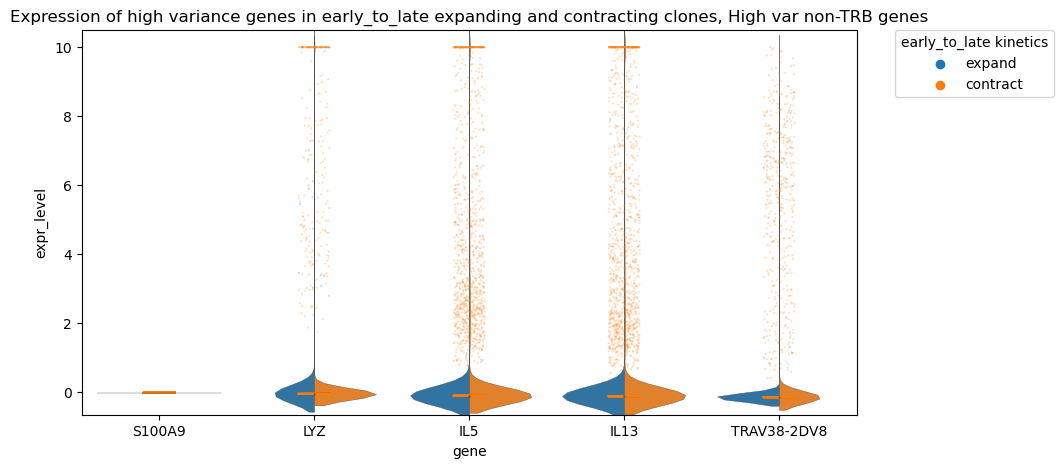

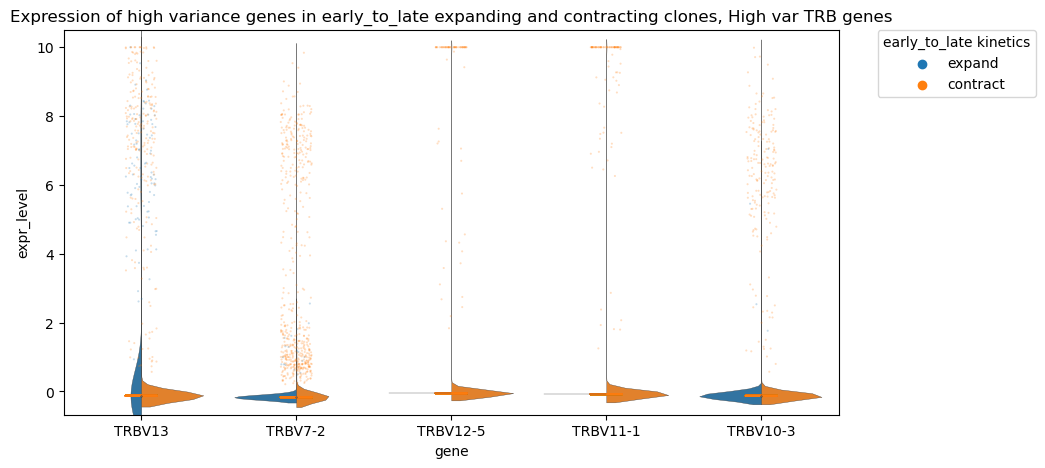

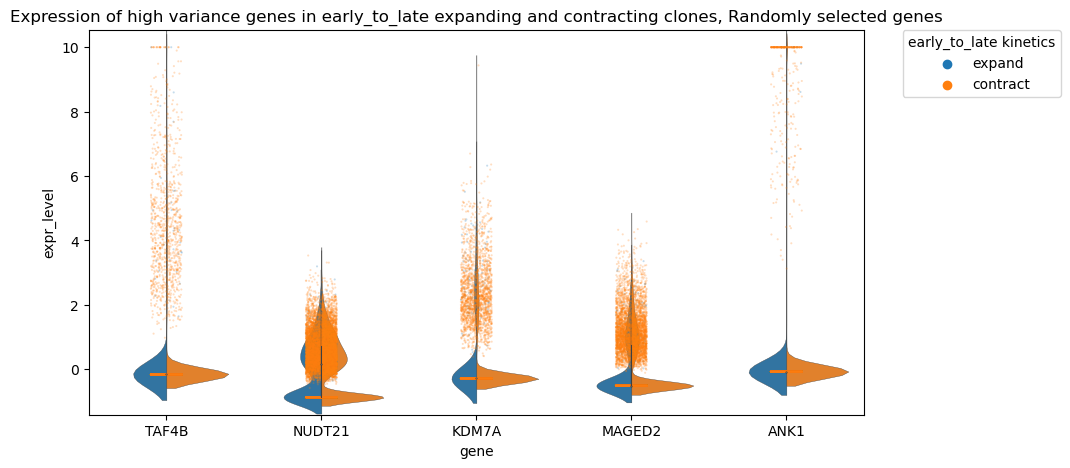

In [8]:
make_violin_plots_for_timepoint("early_to_late")

#### As a sanity check, look more closely into the expression of S100A9, which is a gene that is highly expressed but has very little expression

In [9]:
expr.var.loc["S100A9"]

mt                           False
n_cells_by_counts               77
mean_counts               0.019689
pct_dropout_by_counts     99.87614
total_counts                1224.0
n_cells                         77
highly_variable               True
means                     0.013921
dispersions               4.757143
dispersions_norm         14.140092
trb                          False
mean                       0.00145
std                       0.058021
Name: S100A9, dtype: object

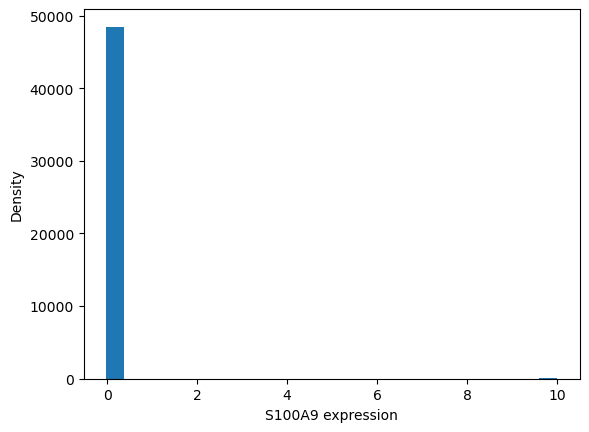

In [10]:
plt.hist(expr_df["S100A9"], bins=25)
plt.xlabel("S100A9 expression")
plt.ylabel("Density")
plt.show()

# it seems like it was only expressed in a very small population of cells (77) and ust happens to have pretty high dispersion because of the few cells that had high expression

## Plot differential expression across timepoints of clones that expand vs contract

In [11]:
meta = pd.read_csv("geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))

expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)

/var/folders/pf/xdq1hzpd1sg02zxbtb77nhm80000gn/T/ipykernel_35907/1193207089.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]


In [56]:
barcode_kinetics = pd.read_csv("barcode_kinetics_2.csv", index_col=0)
barcodes_w_sc_and_tcr = set(barcode_kinetics.index) & set(expr.obs.index)
barcode_kinetics = barcode_kinetics.loc[list(barcodes_w_sc_and_tcr)]

In [58]:
# Filter to just cells for each time point
ip_to_early_expr = expr[expr.obs["time_point_type"]=="IP"].copy()
kin_ip_to_early = barcode_kinetics["early"].dropna()
ip_to_early_expr = ip_to_early_expr[ip_to_early_expr.obs.index.isin(kin_ip_to_early.index)]
ip_to_early_expr.obs = ip_to_early_expr.obs.assign(kinetics= kin_ip_to_early.loc[ip_to_early_expr.obs.index], dtype="category")

early_to_contraction_expr = expr[expr.obs["time_point_type"]=="Early"].copy()
kin_early_to_contr = barcode_kinetics["contraction"].dropna()
early_to_contraction_expr = early_to_contraction_expr[early_to_contraction_expr.obs.index.isin(kin_early_to_contr.index)]
early_to_contraction_expr.obs = early_to_contraction_expr.obs.assign(kinetics= kin_early_to_contr.loc[early_to_contraction_expr.obs.index], dtype="category")

contr_to_late_expr = expr[expr.obs["time_point_type"]=="Contraction"].copy()
kin_contr_to_late = barcode_kinetics["late"].dropna()
contr_to_late_expr = contr_to_late_expr[contr_to_late_expr.obs.index.isin(kin_contr_to_late.index)]
contr_to_late_expr.obs = contr_to_late_expr.obs.assign(kinetics= kin_contr_to_late.loc[contr_to_late_expr.obs.index], dtype="category")


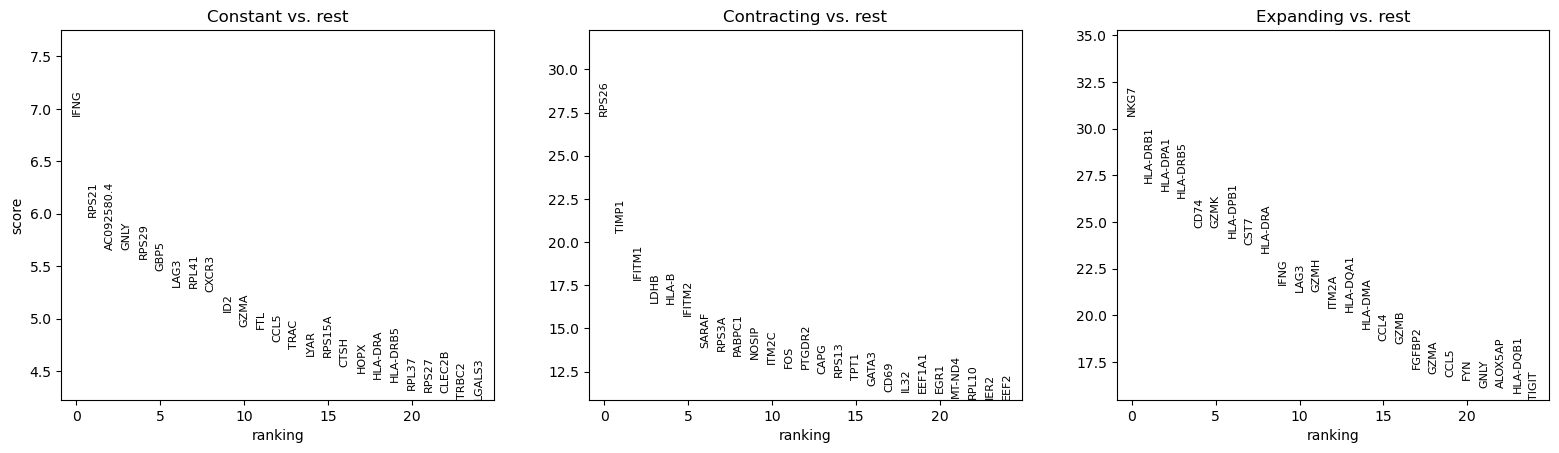

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


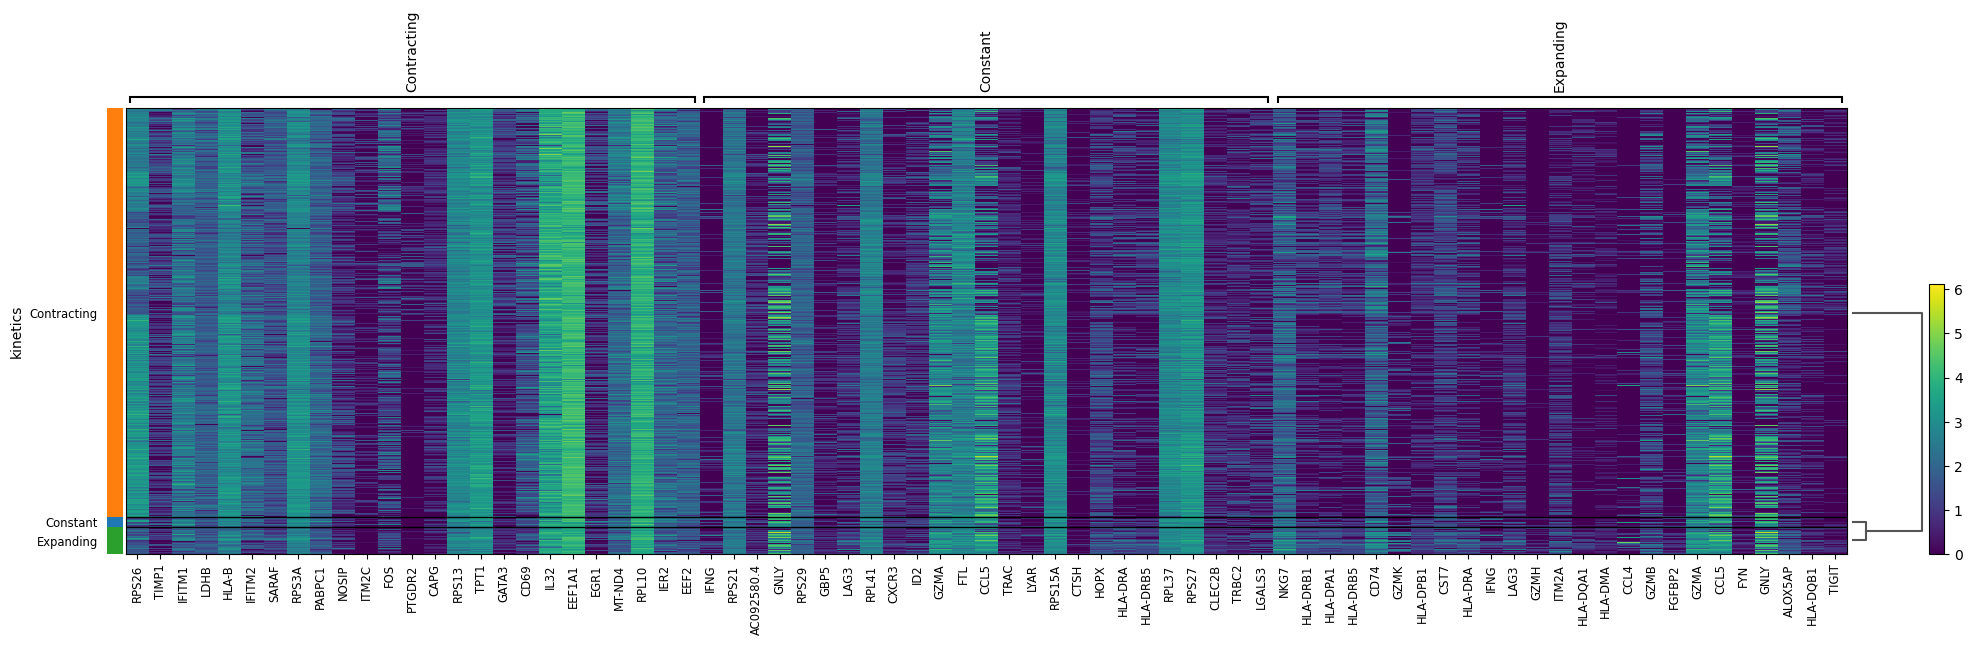

In [53]:
sc.tl.rank_genes_groups(ip_to_early_expr, groupby="kinetics", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(ip_to_early_expr, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(ip_to_early_expr, n_genes = 25, key="rank_genes_groups", groupby="kinetics", show_gene_labels=True)

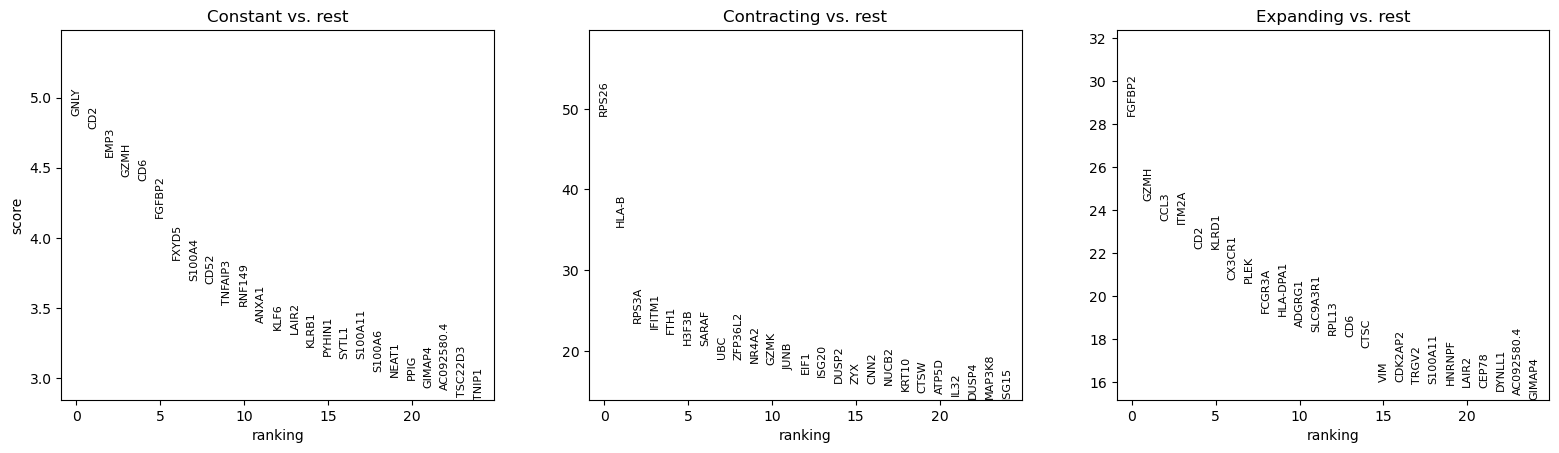

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


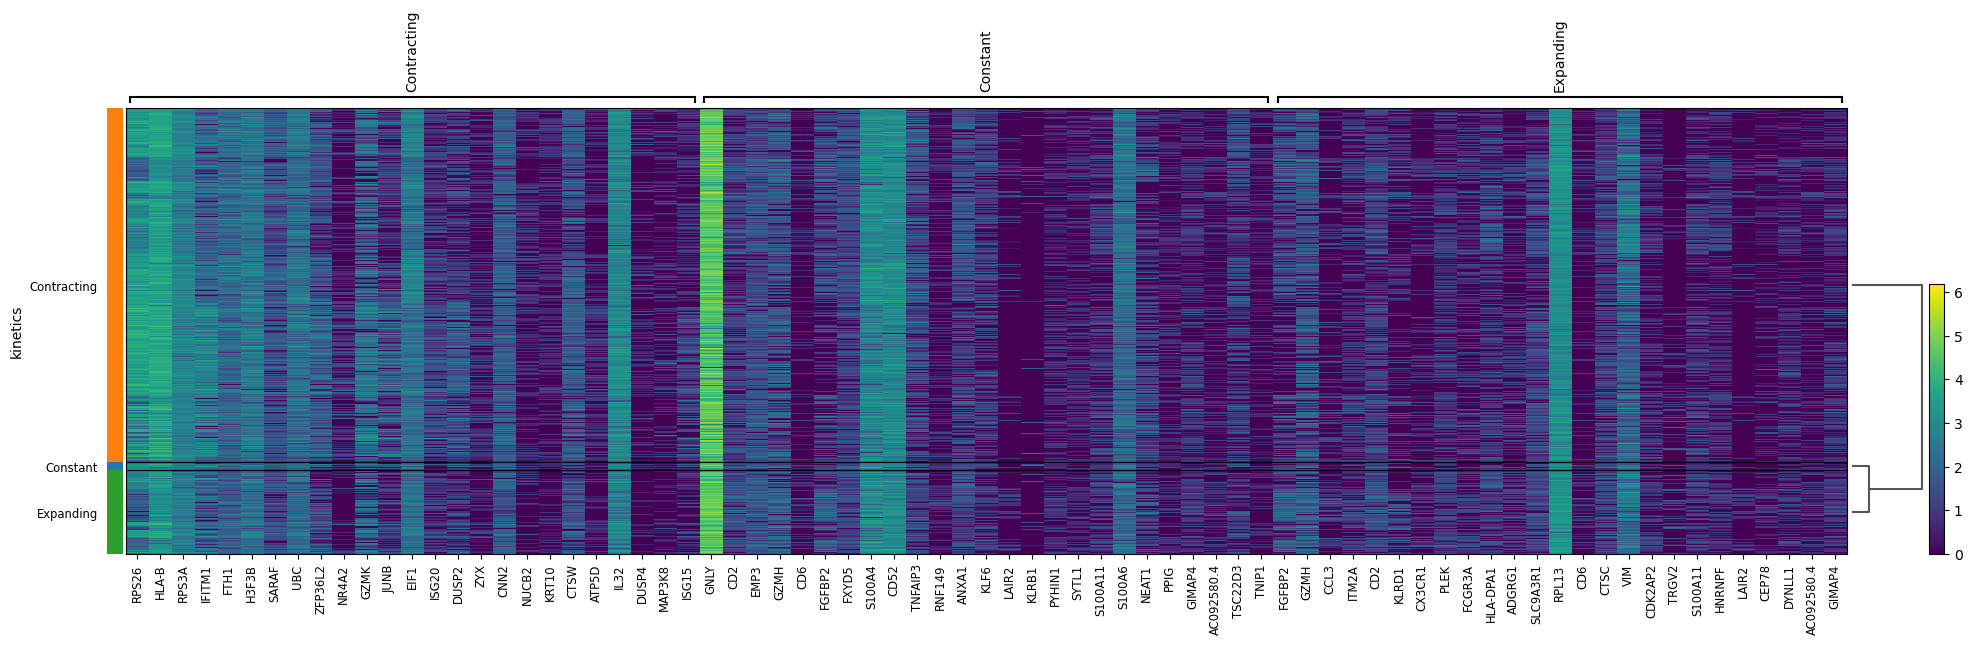

In [54]:
sc.tl.rank_genes_groups(early_to_contraction_expr, groupby="kinetics", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(early_to_contraction_expr, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(early_to_contraction_expr, n_genes = 25, key="rank_genes_groups", groupby="kinetics", show_gene_labels=True)

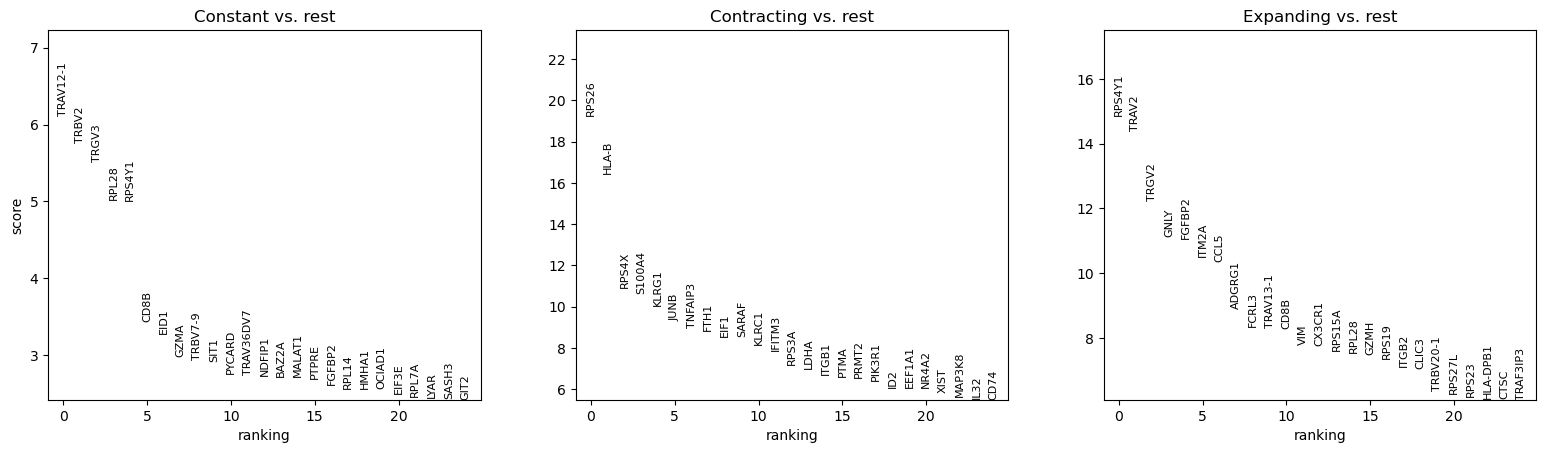

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


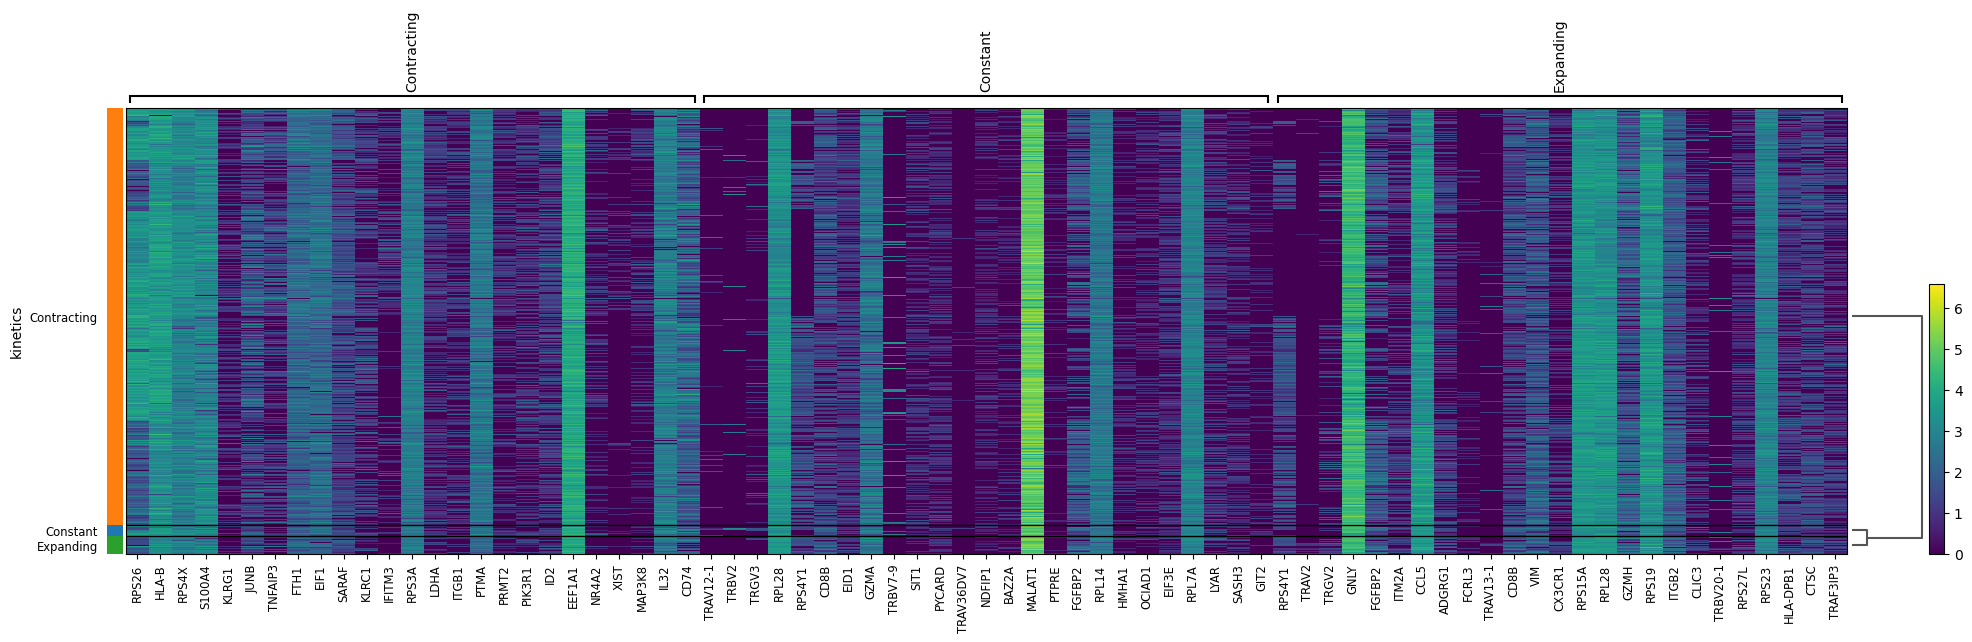

In [59]:
sc.tl.rank_genes_groups(contr_to_late_expr, groupby="kinetics", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(contr_to_late_expr, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(contr_to_late_expr, n_genes = 25, key="rank_genes_groups", groupby="kinetics", show_gene_labels=True)